# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt
import skimage

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers.recurrent import LSTM

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# Source path
train_path = './Project_data/train'
val_path = './Project_data/val'

In [5]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 50

### EDA

./Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new
./Project_data/train/WIN_20180925_17_33_08_Pro_Left_Swipe_new
./Project_data/train/WIN_20180925_18_02_58_Pro_Thumbs_Down_new
./Project_data/train/WIN_20180925_17_51_17_Pro_Thumbs_Up_new
./Project_data/train/WIN_20180926_17_29_23_Pro_Stop_new


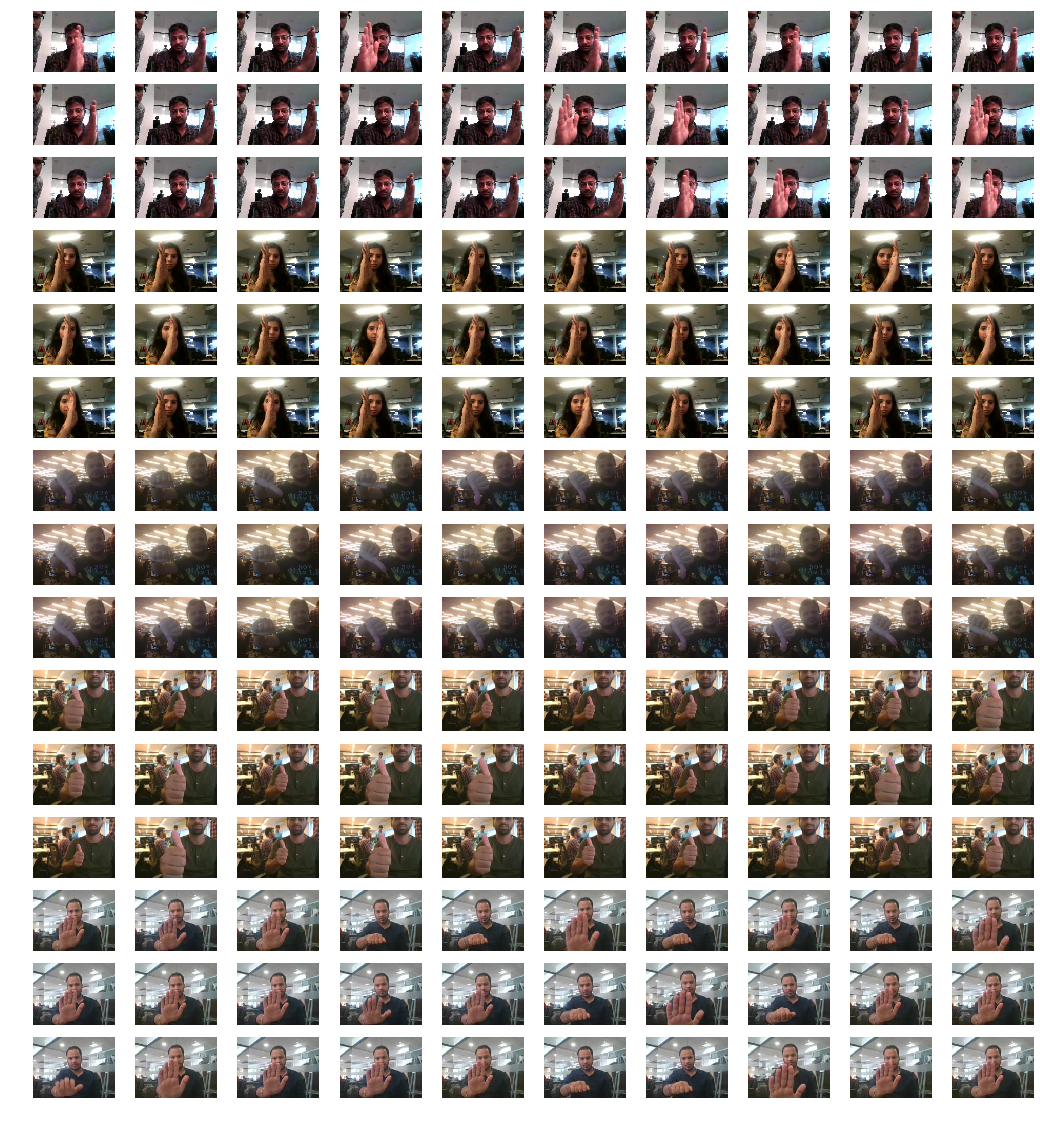

In [6]:
# Let's take a look at the images in the train folder

num_folders = 5
num_image = num_folders * 30
i = 0

plt.figure(figsize=(18,20))

#for idx in range(num_folders):
for idx in [0,2,1,3,6]:
    folder = train_doc[idx].split(';')[0]
    path = train_path+'/'+folder
    files_list = os.listdir(path)
    print(path)
    
    for file in files_list[:num_image]:
        file_path = path + '/' + file
        img = skimage.io.imread(file_path)
        i = i+1
        plt.subplot(num_image/10, 10, i)
        plt.axis('off')
        plt.imshow(img)

#### Raw Image

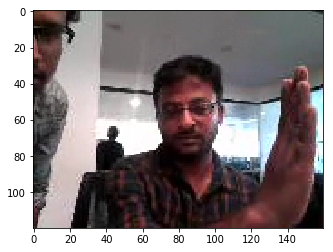

In [11]:
path = './Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new'
#path = './Project_data/train/WIN_20180925_18_02_58_Pro_Thumbs_Down_new'
files_list = os.listdir(path)
file_path = path + '/' + files_list[2]
img = skimage.io.imread(file_path)
plt.imshow(img)

#### Resize Image to 120 X 120

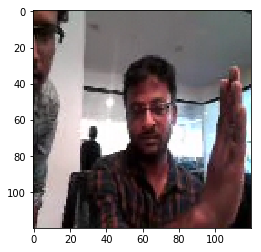

In [12]:
# Resize the image to uniform size
img = cv2.resize(img, (120,120))
plt.imshow(img)

#### Gray Scale Image

(120, 120)


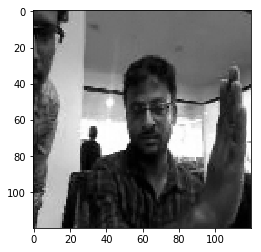

In [13]:
#Change to Grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img_gray.shape)
plt.imshow(img_gray, cmap='gray')

#### Cropped Image

(100, 100, 3)


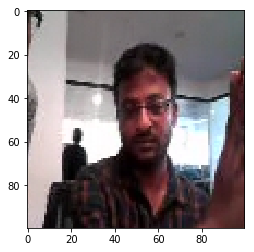

In [14]:
# Cropping the image
cropped_img = img[10:110, 10:110]
plt.imshow(cropped_img)
print(cropped_img.shape)

#### GaussianBlur Image

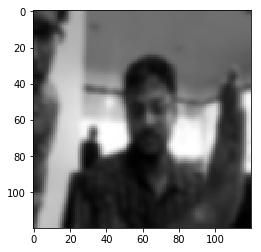

In [15]:
#Clean up image using GaussianBlur
img_gausblur = cv2.GaussianBlur(img_gray, (7,7), 0 )
plt.imshow(img_gausblur, cmap='gray')

#### Canny Edge Image

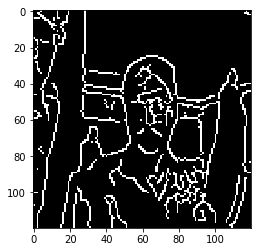

In [16]:
# Extract Canny edges
img_canny = cv2.Canny(img_gausblur, 10, 70)
plt.imshow(img_canny, cmap='gray')

#### Invert Binarize Canny Image

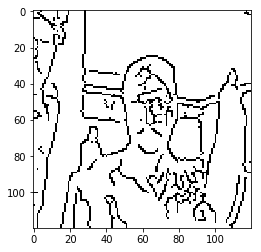

In [17]:
#Invert Binarize the image
_,img_thresh = cv2.threshold(img_canny, 70, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_thresh, cmap='gray')

#### Laplace-GaussianBlur Image

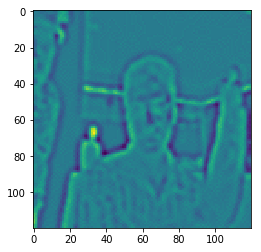

In [18]:
#Change to Grayscale
img_lap = cv2.Laplacian(img_gausblur,cv2.CV_64F)
#img_lap = cv2.Laplacian(cv2.medianBlur(img_rgb[:,:,0],15),cv2.CV_64F)
#img_lap = cv2.Laplacian(img[:,:,0], 10)
plt.imshow(img_lap)

#### Sharpened

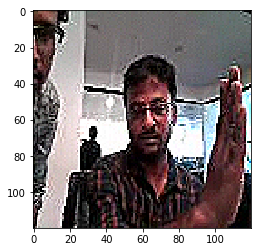

In [19]:
#kernel = np.array([[-1,-1,-1],
#                   [-1,10,-1],
#                   [-1,-1,-1]])

kernel = np.array([[0, -1, 0], 
                   [-1, 5, -1], 
                   [0, -1, 0]])

img_sharpened = cv2.filter2D(img, -1, kernel)
plt.imshow(img_sharpened)

#### Sharpened Laplace-GaussianBlur Image

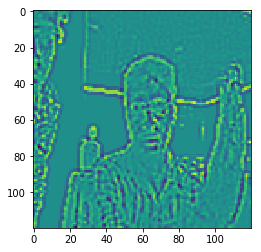

In [20]:
#Change to Grayscale
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kernel_sharpening = np.array([[-1,-1,-1],
                              [-1,10,-1],
                              [-1,-1,-1]])
img_sharpened = cv2.filter2D(img_rgb, -1, kernel_sharpening)
img_gausblur = cv2.GaussianBlur(img_sharpened[:,:,0],(3,3),0)
img_lap = cv2.Laplacian(img_gausblur,cv2.CV_64F)
plt.imshow(img_lap)

#### Dilate GaussianBlur Image

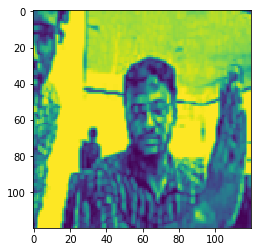

In [21]:
img_morph = cv2.morphologyEx(img_gausblur, cv2.MORPH_DILATE, (3,3))
plt.imshow(img_morph)

#### Laplace-Morphed Image

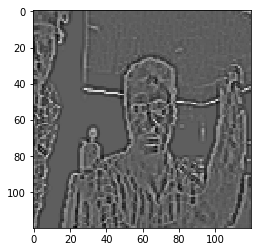

In [22]:
img_lap = cv2.Laplacian(img_morph,cv2.CV_64F)
plt.imshow(img_lap, cmap='gray')

#### Difference Between Frames

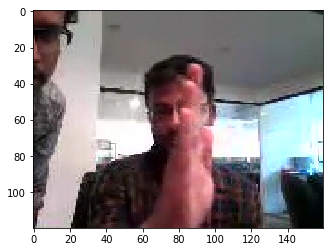

In [23]:
# Find diff between images
path = './Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new'
files_list = os.listdir(path)
file_path = path + '/' + files_list[0]
img1 = skimage.io.imread(file_path)
plt.imshow(img1)

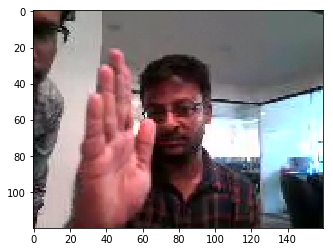

In [24]:
path = './Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new'
files_list = os.listdir(path)
file_path = path + '/' + files_list[15]
img2 = skimage.io.imread(file_path)
plt.imshow(img2)

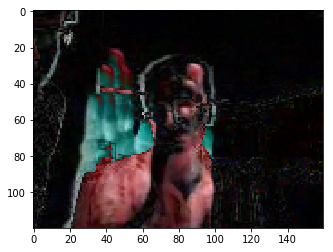

In [25]:
diff = cv2.absdiff(img1, img2)
plt.imshow(diff)

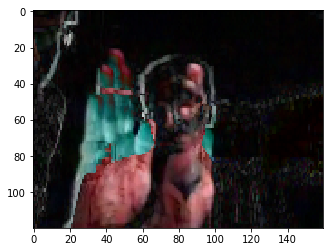

In [26]:
img_dilate = cv2.dilate(diff, (5,5), 4)
plt.imshow(img_dilate)

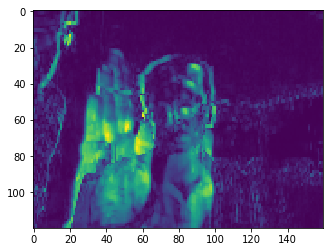

In [27]:
mask = cv2.cvtColor(img_dilate, cv2.COLOR_BGR2GRAY)
plt.imshow(mask)

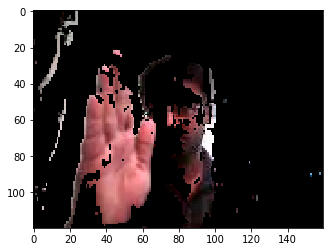

In [28]:
th = 50
imask =  mask>th

canvas = np.zeros_like(img2, np.uint8)
canvas[imask] = img2[imask]
plt.imshow(canvas)

**Sharpened Laplace-GaussianBlur Image** and **Laplace-GaussianBlur Image** preprocessing techniques seem to be working well with the images

### Affine Transforms

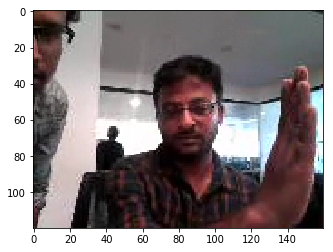

In [29]:
path = './Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new'
#path = './Project_data/train/WIN_20180925_18_02_58_Pro_Thumbs_Down_new'
files_list = os.listdir(path)
file_path = path + '/' + files_list[2]
img = skimage.io.imread(file_path)
plt.imshow(img)

#### Image Translation

120 160
[[  1.         0.       -26.666666]
 [  0.         1.       -20.      ]]


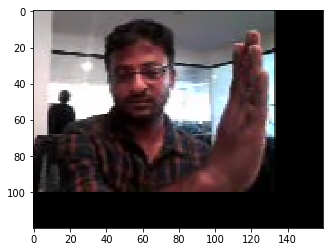

In [30]:
height, width = img.shape[:2]
print(height,width)
T = np.float32([[1,0,-width/6],[0,1,-height/6]])
print(T)
img_translate = cv2.warpAffine(img,T,(width,height))
plt.imshow(img_translate)

#### Image Rotation

120 160
[[  1.         0.       -26.666666]
 [  0.         1.       -20.      ]]


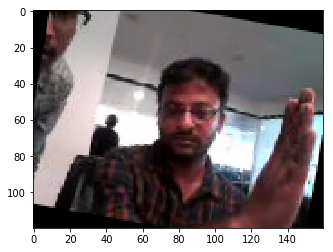

In [31]:
height, width = img.shape[:2]
print(height,width)
rotation_mat = cv2.getRotationMatrix2D((width/2, height/2), -10, 1)
print(T)
img_rotation = cv2.warpAffine(img, rotation_mat,(width,height))
plt.imshow(img_rotation)

#### Resizing with skew

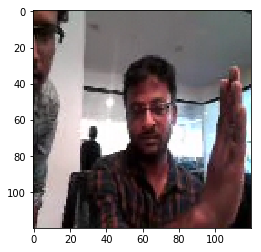

In [32]:
#resize the image with skew to 120,120,3
img_resize = cv2.resize(img, (120,120), cv2.INTER_LANCZOS4)
plt.imshow(img_resize)

#### Horizontal flipping

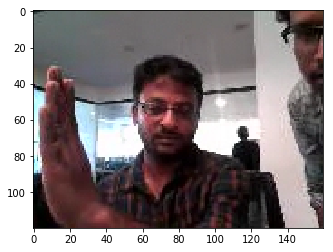

In [33]:
#resize the image with skew to 120,120,3
# 1 - Hori , 0 - Vert, -1 - Both 
img_flip = cv2.flip(img, 1)
plt.imshow(img_flip)

#### Add Lights

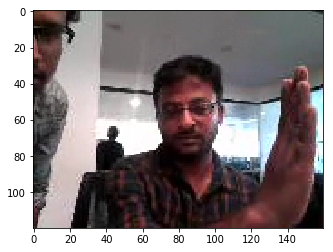

In [34]:
gamma = np.random.randint(1,4)
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255
                  for i in np.arange(0, 256)]).astype("uint8")

img_light = cv2.LUT(img, table)
plt.imshow(img_light)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
from keras.layers.recurrent import LSTM

In [7]:
class data_generator:
    def __init__(self, width=120, height=120, frames=30, channel=3, crop = True, 
                 normalize = False, flip = False, edge = False, affine = False):
        """
            This is the Constructor. 
            This function will be called when we will create the object of data_generator.
            'self' is the instance of data_generator class, we will access class attributes with this.
            
        """ 
        self.width = width   # width of the image
        self.channel = channel # number of channels
        self.affine = affine # augment
        self.height = height # height of the image
        self.frames = frames # depth of the video frames
        self.normalize =  normalize # Normalization
        self.edge = edge # edge detection
        self.flip = flip # Flip the image
        self.crop = crop # Crop the image

    def load_images_batch(self, source_path, folder_list, batch_num, batch_size, t):
    
        """
            We build the batch data here. 
            Morphological transformations are performed on the basis of attributes of the data_generator class.
            
            1. create a list of image numbers.
            2. iterate over the batch_size.
            3. Iterate over the frames/images of a folder to read them in.
            4. Perfrom morphological transormations if applicable.
            
        """ 
        batch_data = np.zeros((batch_size, self.frames, self.width, self.height, self.channel)) 
        batch_labels = np.zeros((batch_size,5))
        # Build an agumented batch data
        if self.affine:
            batch_data_augment = np.zeros((batch_size, self.frames, self.width, self.height, self.channel)) 
            batch_labels_augment = np.zeros((batch_size,5))
        if self.flip:
            batch_data_flipped = np.zeros((batch_size, self.frames, self.width, self.height, self.channel)) 
            batch_labels_flipped = np.zeros((batch_size,5))

        #create a list of image numbers you want to use for a particular video
        img_idx = [x for x in range(0, self.frames)] 

        for folder in range(batch_size): # iterate over the batch_size
            # read all the images in the folder
            imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
            # Generate a random affine to be used for buidling agumented data set
            dx, dy = np.random.randint(-1.7, 1.8, 2)
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            
            #  Iterate over the frames/images of a folder to read them in
            for idx, item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes  
                if self.crop:
                    if image.shape[0] != image.shape[1]:
                        image = image[0:120, 20:140]
                      
                # If normalize is set normalize the image else use the raw image.
                if self.normalize:
                    img = cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)
                    resized_image = img/127.5-1         
                else:
                    resized_image = cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)
                # If the input is edge detected image
                if self.edge:
                    resized_image = np.zeros((resized_image.shape[0], resized_image.shape[1], resized_image.shape[2]))
                    resized_image[:,:,0] = cv2.Laplacian(cv2.GaussianBlur(resized_image[:,:,0],(3,3),0),cv2.CV_64F)
                    resized_image[:,:,1] = cv2.Laplacian(cv2.GaussianBlur(resized_image[:,:,1],(3,3),0),cv2.CV_64F)
                    resized_image[:,:,2] = cv2.Laplacian(cv2.GaussianBlur(resized_image[:,:,2],(3,3),0),cv2.CV_64F)
                
                batch_data[folder,idx] = resized_image
                if self.affine:
                    batch_data_augment[folder,idx] = cv2.warpAffine(resized_image, M, (resized_image.shape[0], resized_image.shape[1]))
                if self.flip:
                    batch_data_flipped[folder,idx] = np.flip(resized_image,1) 

            batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
            
            if self.affine:
                batch_labels_augment[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
            
            if self.flip:
                if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flipped[folder, 1] = 1
                elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flipped[folder, 0] = 1
                else:
                    batch_labels_flipped[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        if self.affine:
            batch_data = np.append(batch_data, batch_data_augment, axis = 0) 
            batch_labels = np.append(batch_labels, batch_labels_augment, axis = 0) 
        if self.flip:
            batch_data = np.append(batch_data, batch_data_flipped, axis = 0) 
            batch_labels = np.append(batch_labels, batch_labels_flipped, axis = 0) 

        return batch_data, batch_labels
    
    def generator(self, source_path, folder_list, batch_size):    
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                # you yield the batch_data and the batch_labels, remember what does yield do
                yield self.load_images_batch(source_path, folder_list, batch, batch_size, t) 
            
            # Code for the remaining data points which are left after full batches
            if (len(folder_list) != batch_size*num_batches):
                batch_size = len(folder_list) - (batch_size*num_batches)
                yield self.load_images_batch(source_path, folder_list, num_batches, batch_size, t)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model - 1

In [9]:
def convolution_with_dropouts(input_shape, nb_classes):
        
    """
        Building a 3D convolutional network, with Dropouts after the Convolution layers and Dense layers.
        We are NOT using any Batch normalization in this Model.

        Number of Convolution units = 4
        Number of Maxpooling = 3
        Number of Dropouts = 4
    """  
    # Define model
    model = Sequential()

    # Convolution unit - 1
    model.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv3D(16, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
    model.add(Dropout(0.25))

    # Convolution unit - 2
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
    model.add(Dropout(0.25))

    # Convolution unit - 3
    model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    #softmax layer
    model.add(Dense(nb_classes, activation='softmax'))

    return model 

### Model - 2

In [10]:
def convolution_no_dropouts_1_batch_normalization(input_shape, nb_classes):
        
    """
        Building a 3D convolutional network, without any Dropouts after the Convolution layers 
        but 1 Droput after Dense layer and Batch normalization in the Fully Connected layer.

        Number of Convolution units = 3
        Number of Maxpooling = 3
        Number of Dropouts = 2
    """  
    # Define model
    model = Sequential()

    # Convolution unit - 1
    model.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv3D(16, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))

    # Convolution unit - 2
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))

    # Convolution unit - 3
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    return model

### Model - 3

In [11]:
def convolution_with_BatchNormalization(input_shape, nb_classes):

    """
        Building a 3D convolutional network, without any Dropouts after the Convolution layers 
        but Droput in Fully Connected layer and Batch normalization in the Convolution layers.

        Number of Convolution units = 4
        Number of Maxpooling = 4
        Number of Dropouts = 3
    """  

    # Input
    input_shape=(30,120,120,3)

    # Define model
    model = Sequential()

    # Convolution unit - 1
    model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # Convolution unit - 2
    model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # Convolution unit - 3
    model.add(Conv3D(32,kernel_size=(1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # Convolution unit - 4
    model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #softmax layer
    model.add(Dense(5, activation='softmax'))
    return model

### Model - 4

In [12]:
def cnn_rnn_lstm(input_shape, nb_classes):
        
    """CNN with RNN.

       Standard CNN + RNN architecture in which we pass the images of a video through a CNN 
       which extracts a feature vector for each image, and then pass the sequence of these 
       feature vectors through an RNN.

       Here we are using LSTM (Long Short Term Memory) for the RNN

    """
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
        activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(Conv2D(32, (3,3),
        kernel_initializer="he_normal", activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=False, dropout=0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    return model

### Model - 5

In [13]:
def cnn_rnn_gru(input_shape, nb_classes):
        
        
    """CNN with RNN.

       Standard CNN + RNN architecture in which we pass the images of a video through a CNN 
       which extracts a feature vector for each image, and then pass the sequence of these 
       feature vectors through an RNN.

       Here we are using GRU (Gated Recurrent Unit) for the RNN

    """
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
        activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(Conv2D(32, (3,3),
        kernel_initializer="he_normal", activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=False, dropout=0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    return model

This def is to train the Model. We have used Adam optimizer, Categorical Crossentropy loss function Categorical Accuracy metrices.

In [14]:
def train_model(batch_size, num_epochs, model, train_generator, val_generator):

    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print('# batch size =', batch_size)    
    print('# Numbe of epochs =', num_epochs)
    
    #Adam optimizer
    optimiser = Adam() 
    # We have used Adam optimizer, Categorical Crossentropy loss function Categorical Accuracy metrices.
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=False, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    history = History()
    callbacks_list = [checkpoint, LR, history]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    plt.figure(figsize=(18,4))
    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    K.clear_session()

<h3> Experiment - 1</h3>
Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image as it is without any Morphological preprocessing.

Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation.

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40, 40, 16)    0         
_____________________________________________

34/34 [==============================] - 26s 761ms/step - loss: 12.9577 - categorical_accuracy: 0.1961 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00016: saving model to model_init_2019-03-1613_13_35.578441/model-00016-12.95768-0.19608-13.53920-0.16000.h5
Epoch 17/20
34/34 [==============================] - 26s 761ms/step - loss: 13.7478 - categorical_accuracy: 0.1471 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00017: saving model to model_init_2019-03-1613_13_35.578441/model-00017-13.74779-0.14706-13.53920-0.16000.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 18/20
34/34 [==============================] - 26s 761ms/step - loss: 13.9058 - categorical_accuracy: 0.1373 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00018: saving model to model_init_2019-03-1613_13_35.578441/model-00018-13.90581-0.13725-13.53920-0.16000.h5
Epoch 19/20
34/34 [==============================] - 26s 762ms/step - los

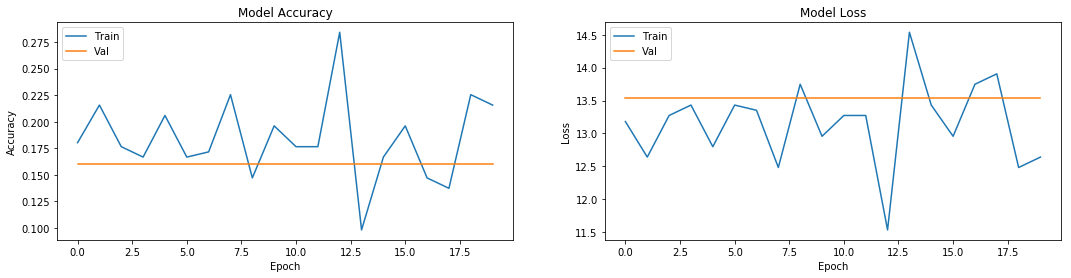

In [15]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_dropouts(input_shape, num_classes)


# Batch size
batch_size = 20

# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)

# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 2</h3>
Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40, 40, 16)    0         
_____________________________________________

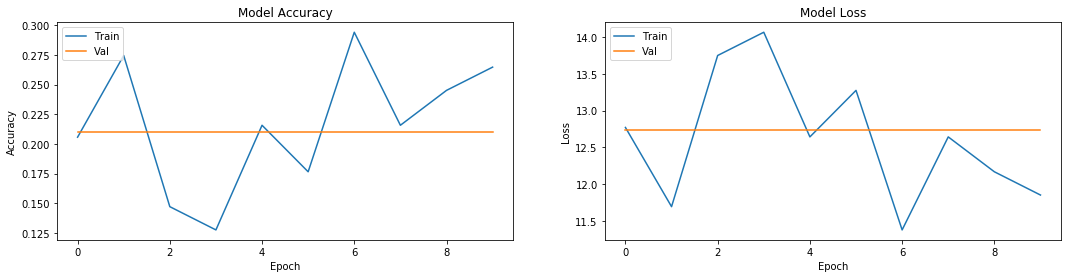

In [16]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_dropouts(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 10

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 3</h3>
Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized.

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 40, 40, 16)    0         
_____________________________________________

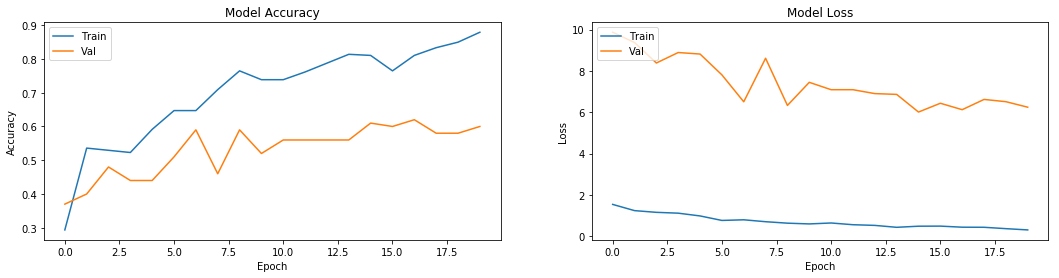

In [16]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_dropouts(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 4</h3>
Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized. <br>
4. Center crop of the images to retain the middle of the frame

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40, 40, 16)    0         
_____________________________________________

34/34 [==============================] - 35s 1s/step - loss: 0.7453 - categorical_accuracy: 0.6797 - val_loss: 6.9308 - val_categorical_accuracy: 0.5700

Epoch 00016: saving model to model_init_2019-03-1617_54_00.488087/model-00016-0.74528-0.67974-6.93078-0.57000.h5
Epoch 17/20
34/34 [==============================] - 35s 1s/step - loss: 0.8303 - categorical_accuracy: 0.6471 - val_loss: 6.8893 - val_categorical_accuracy: 0.5700

Epoch 00017: saving model to model_init_2019-03-1617_54_00.488087/model-00017-0.83035-0.64706-6.88932-0.57000.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 18/20
34/34 [==============================] - 35s 1s/step - loss: 0.7606 - categorical_accuracy: 0.7222 - val_loss: 6.8974 - val_categorical_accuracy: 0.5700

Epoch 00018: saving model to model_init_2019-03-1617_54_00.488087/model-00018-0.76059-0.72222-6.89740-0.57000.h5
Epoch 19/20
34/34 [==============================] - 35s 1s/step - loss: 0.6649 - categorical_

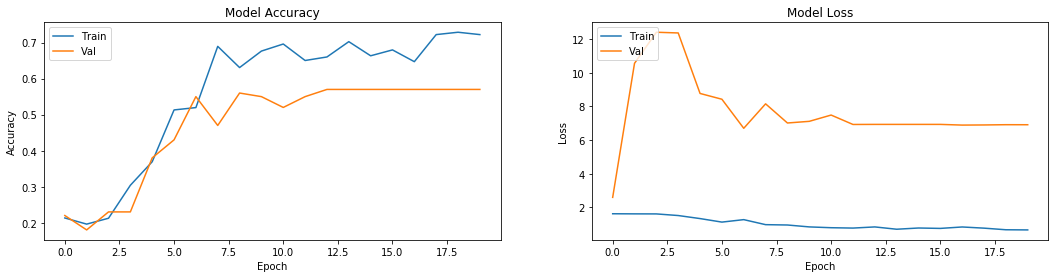

In [16]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True, crop=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_dropouts(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 5</h3>
Here we are training the 1st Model that has no dropout. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized. <br>
4. Center crop of the images to retain the middle of the frame <br>
5. Edge detection for finding the boundaries of objects within images

# training sequences = 663
# validation sequences = 100
# batch size = 15
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40, 40, 16)    0         
_____________________________________________

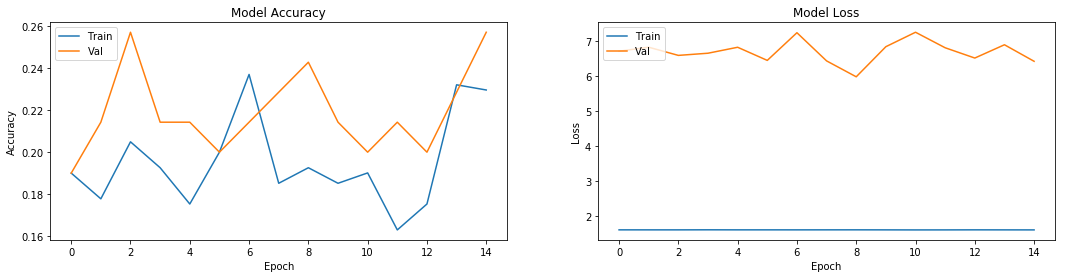

In [17]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True, crop=True, edge=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_dropouts(input_shape, num_classes)

# Batch size
batch_size = 15
# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3><u>Experimentation with 2nd Model starts from here </u><h3> 

<h3> Experiment - 6</h3>
Here we are training the 2nd Model that has no dropouts and has 1 Batchnormalization. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_____________________________________________

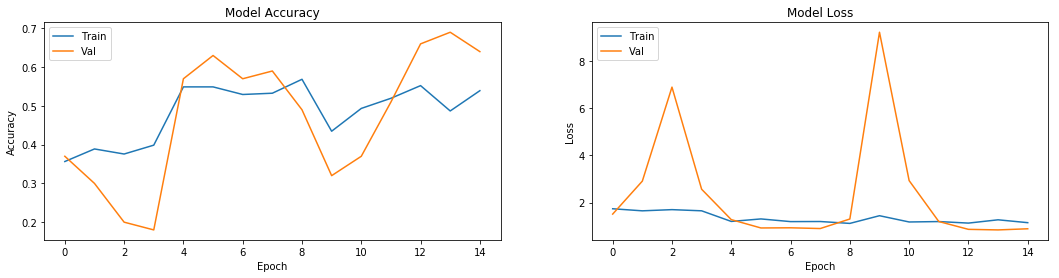

In [18]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_no_dropouts_1_batch_normalization(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 7</h3>
Here we are training the 2nd Model that has no dropouts and has 1 Batchnormalization. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized. 

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_____________________________________________

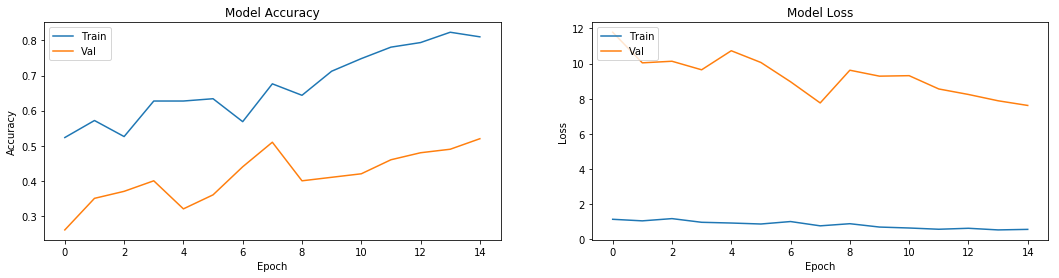

In [15]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_no_dropouts_1_batch_normalization(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)

# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 8</h3>
Here we are training the 2nd Model that has no dropouts and has 1 Batchnormalization. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized. <br>
4. Center crop of the images to retain the middle of the frame 

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_____________________________________________

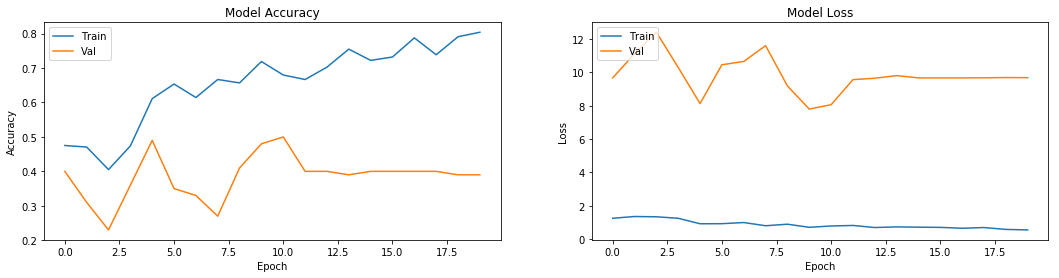

In [19]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True, crop=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_no_dropouts_1_batch_normalization(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3><u>Experimentation with 3rd Model starts from here </u><h3> 

<h3> Experiment - 9</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. The input images are normalized. <br>

Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_____________________________________________

34/34 [==============================] - 15s 439ms/step - loss: 1.1140 - categorical_accuracy: 0.5588 - val_loss: 0.9909 - val_categorical_accuracy: 0.5600

Epoch 00017: saving model to model_init_2019-03-1606_56_12.153118/model-00017-1.11399-0.55882-0.99093-0.56000.h5
Epoch 18/20
34/34 [==============================] - 15s 436ms/step - loss: 0.9522 - categorical_accuracy: 0.6209 - val_loss: 0.9778 - val_categorical_accuracy: 0.5500

Epoch 00018: saving model to model_init_2019-03-1606_56_12.153118/model-00018-0.95220-0.62092-0.97781-0.55000.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 19/20
34/34 [==============================] - 16s 475ms/step - loss: 1.0401 - categorical_accuracy: 0.6046 - val_loss: 0.8711 - val_categorical_accuracy: 0.6400

Epoch 00019: saving model to model_init_2019-03-1606_56_12.153118/model-00019-1.04008-0.60458-0.87114-0.64000.h5
Epoch 20/20
34/34 [==============================] - 15s 441ms/step - loss: 0.9673 - c

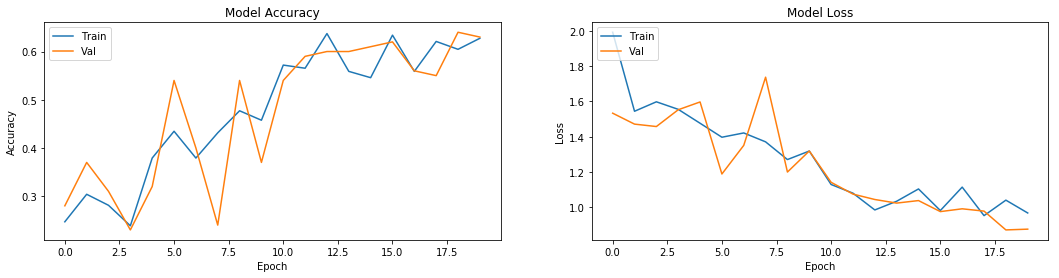

In [15]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 10</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br>
3. Normalize

# training sequences = 663
# validation sequences = 100
# batch size = 20
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_____________________________________________

34/34 [==============================] - 16s 465ms/step - loss: 1.1446 - categorical_accuracy: 0.4804 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00016: saving model to model_init_2019-03-1606_43_19.011782/model-00016-1.14459-0.48039-12.41093-0.23000.h5
Epoch 17/20
34/34 [==============================] - 16s 464ms/step - loss: 1.1267 - categorical_accuracy: 0.5588 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00017: saving model to model_init_2019-03-1606_43_19.011782/model-00017-1.12675-0.55882-12.41093-0.23000.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 18/20
34/34 [==============================] - 16s 484ms/step - loss: 1.1098 - categorical_accuracy: 0.5359 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00018: saving model to model_init_2019-03-1606_43_19.011782/model-00018-1.10977-0.53595-12.41093-0.23000.h5
Epoch 19/20
34/34 [==============================] - 15s 447ms/step - loss: 1.0

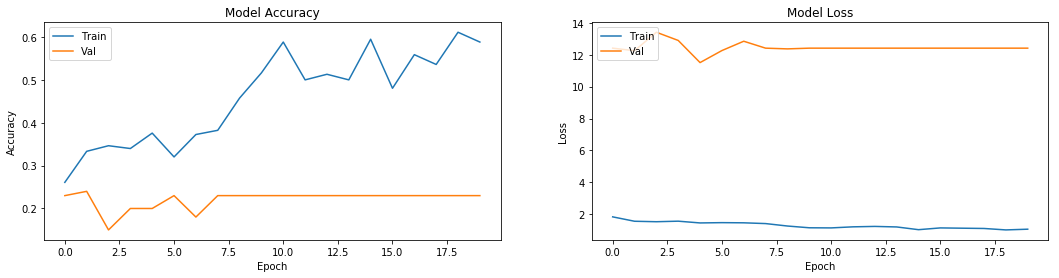

In [14]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 20
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the model
<h3> Experiment - 11</h3>train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 11</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br> <br>

<b>Batch size is reduced from 20 to 10

# training sequences = 663
# validation sequences = 100
# batch size = 10
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_____________________________________________

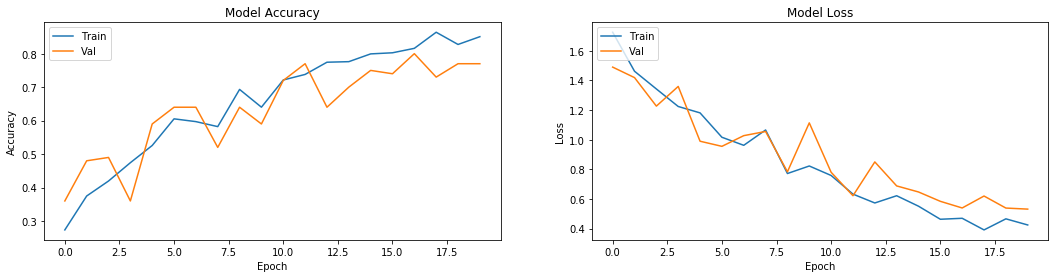

In [16]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 10
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

As we saw in prevous step, the decrease number of batch size increased the Accuracy considerably.

It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize. There have been some attempts to investigate the cause for this generalization drop in the large-batch regime, however the precise answer for this phenomenon is, hitherto unknown.
https://stats.stackexchange.com/a/236393/240950

<h3> Experiment - 12</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br> <br>

<b>Batch size = 5

# training sequences = 663
# validation sequences = 100
# batch size = 5
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
______________________________________________

133/133 [==============================] - 57s 427ms/step - loss: 0.3201 - categorical_accuracy: 0.8797 - val_loss: 0.5018 - val_categorical_accuracy: 0.7900

Epoch 00017: saving model to model_init_2019-03-1609_33_51.296014/model-00017-0.32015-0.87970-0.50175-0.79000.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 18/20
133/133 [==============================] - 59s 447ms/step - loss: 0.2650 - categorical_accuracy: 0.9081 - val_loss: 0.4759 - val_categorical_accuracy: 0.8200

Epoch 00018: saving model to model_init_2019-03-1609_33_51.296014/model-00018-0.26496-0.90810-0.47587-0.82000.h5
Epoch 19/20
133/133 [==============================] - 58s 437ms/step - loss: 0.2274 - categorical_accuracy: 0.9181 - val_loss: 0.4559 - val_categorical_accuracy: 0.8200

Epoch 00019: saving model to model_init_2019-03-1609_33_51.296014/model-00019-0.22742-0.91813-0.45593-0.82000.h5
Epoch 20/20
133/133 [==============================] - 58s 436ms/step - loss: 0.

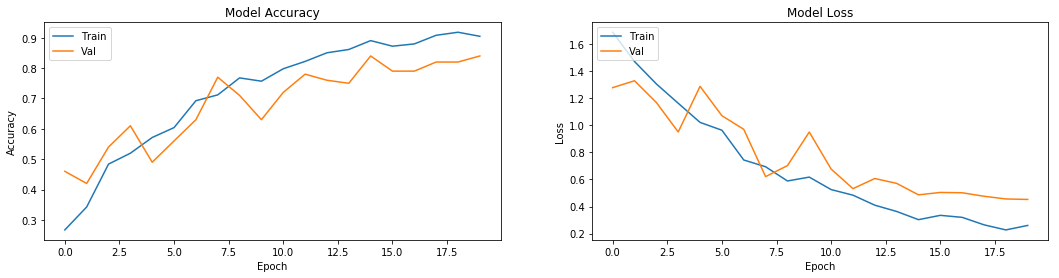

In [17]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 5
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 13</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br> 
3. Center crop of the images to retain the middle of the frame <br> <br>

<b>Again the Batch size is 5

# training sequences = 663
# validation sequences = 100
# batch size = 5
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
______________________________________________

133/133 [==============================] - 54s 409ms/step - loss: 0.3323 - categorical_accuracy: 0.8864 - val_loss: 0.5548 - val_categorical_accuracy: 0.7700

Epoch 00017: saving model to model_init_2019-03-1609_54_23.718291/model-00017-0.33227-0.88638-0.55476-0.77000.h5
Epoch 18/20
133/133 [==============================] - 58s 432ms/step - loss: 0.3243 - categorical_accuracy: 0.8755 - val_loss: 0.5293 - val_categorical_accuracy: 0.8000

Epoch 00018: saving model to model_init_2019-03-1609_54_23.718291/model-00018-0.32435-0.87552-0.52930-0.80000.h5
Epoch 19/20
133/133 [==============================] - 56s 420ms/step - loss: 0.2701 - categorical_accuracy: 0.9098 - val_loss: 0.5546 - val_categorical_accuracy: 0.8100

Epoch 00019: saving model to model_init_2019-03-1609_54_23.718291/model-00019-0.27005-0.90977-0.55463-0.81000.h5
Epoch 20/20
133/133 [==============================] - 57s 430ms/step - loss: 0.3109 - categorical_accuracy: 0.8947 - val_loss: 0.5459 - val_categorical_accurac

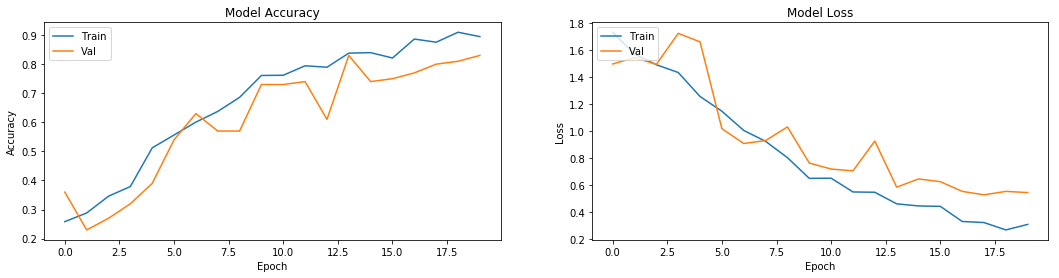

In [18]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, crop=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 5
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 14</h3>
As we could see in previous few experiments that the reduced Batch size produces better results. <br>
Therefore, let us further decrease the Batch size to 3. <br>

<h5> Batch size = 3 </h5>

<h4> This is our final model as we can se below that we could get a 100% validation accuracy </h4>
<h4>loss: 0.0740 - categorical_accuracy: 0.9729 - val_loss: 0.0527 - val_categorical_accuracy: 1.0000 </h54>

# training sequences = 663
# validation sequences = 100
# batch size = 3
# Numbe of epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
______________________________________________

221/221 [==============================] - 85s 385ms/step - loss: 0.0740 - categorical_accuracy: 0.9729 - val_loss: 0.0527 - val_categorical_accuracy: 1.0000

Epoch 00017: saving model to model_init_2019-03-1610_22_26.353003/model-00017-0.07399-0.97285-0.05271-1.00000.h5
Epoch 18/20
221/221 [==============================] - 85s 385ms/step - loss: 0.0646 - categorical_accuracy: 0.9784 - val_loss: 0.2205 - val_categorical_accuracy: 0.8824

Epoch 00018: saving model to model_init_2019-03-1610_22_26.353003/model-00018-0.06457-0.97838-0.22047-0.88235.h5
Epoch 19/20
221/221 [==============================] - 85s 387ms/step - loss: 0.0664 - categorical_accuracy: 0.9809 - val_loss: 0.8741 - val_categorical_accuracy: 0.6765

Epoch 00019: saving model to model_init_2019-03-1610_22_26.353003/model-00019-0.06638-0.98089-0.87414-0.67647.h5

Epoch 00019: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 20/20
221/221 [==============================] - 86s 390ms/step - loss: 0.

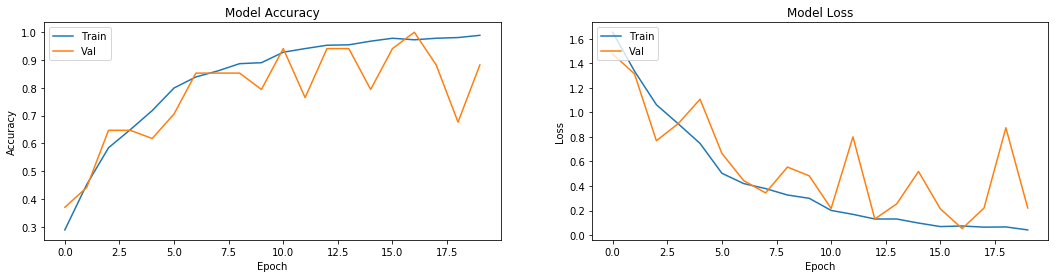

In [19]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, crop=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 3
# Number of Epochs
num_epochs = 20

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3> Experiment - 15</h3>
Here we are training the 3rd Model without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set. <br> 
3. Center crop of the images to retain the middle of the frame <br> 
4. Normalize the imgaes <br>

<b>Again the Batch size is 3

# training sequences = 663
# validation sequences = 100
# batch size = 3
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
______________________________________________

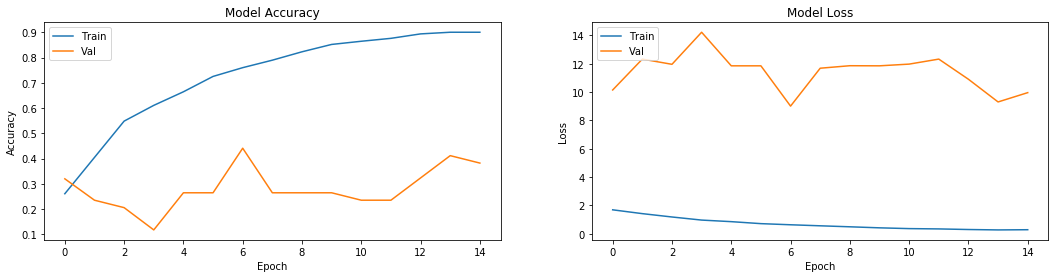

In [20]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, normalize=True, crop=True)
val_gen = data_generator()

# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)
# Number of output classes
num_classes = 5

# Generate the Model
model = convolution_with_BatchNormalization(input_shape, num_classes)

# Batch size
batch_size = 3
# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
#Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)

<h3><u>Experimentation with 4th Model starts from here </u><h3> 
<h5>Having achieved the best accuracy with the small batch size. For experimentation with this CNN+RNN architectures, we will keep the batch size as 3 </h5>

#### Train the CCN + RNN(LASTM) Model

Here we are training the CNN+RNN model in which we pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN. <br>


<h3> Experiment - 16</h3>
This is the 4th Model. <br>
without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.
3. Center crop of the images to retain the middle of the frame 
4. Normalization

# training sequences = 663
# validation sequences = 100
# batch size = 5
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 29, 29, 64)    36928     
______________________________________________

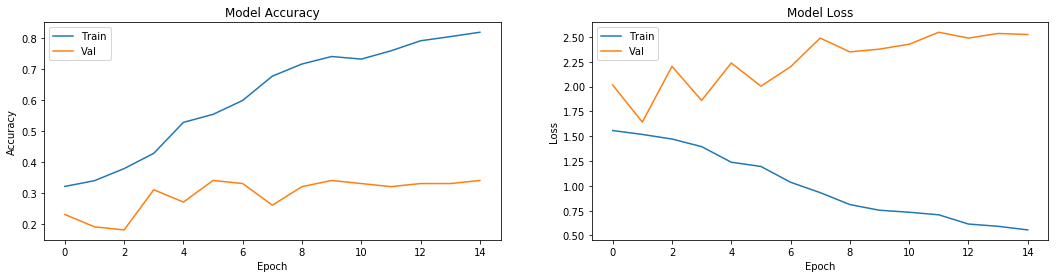

In [23]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, crop=True, normalize=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = cnn_rnn_lstm(input_shape, num_classes)

# Batch size
batch_size = 5

# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 17</h3>
This is again the 4th Model. <br>
without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.
3. Center crop of the images to retain the middle of the frame 

# training sequences = 663
# validation sequences = 100
# batch size = 3
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 29, 29, 64)    36928     
______________________________________________

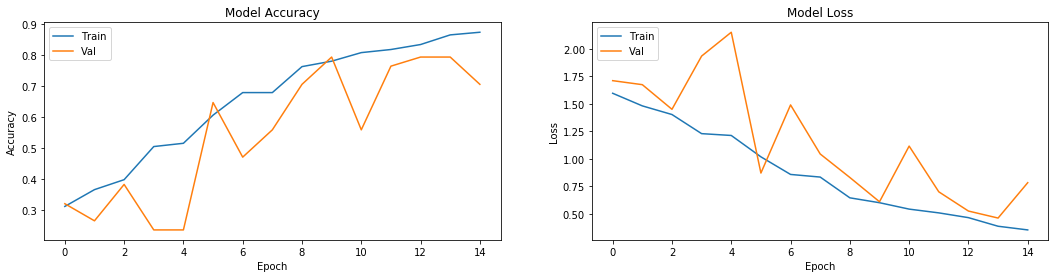

In [15]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True, crop=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = cnn_rnn_lstm(input_shape, num_classes)

# Batch size
batch_size = 3

# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3> Experiment - 18</h3>
This is again the 4th Model. <br>
without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.

# training sequences = 663
# validation sequences = 100
# batch size = 3
# Numbe of epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 29, 29, 64)    36928     
______________________________________________

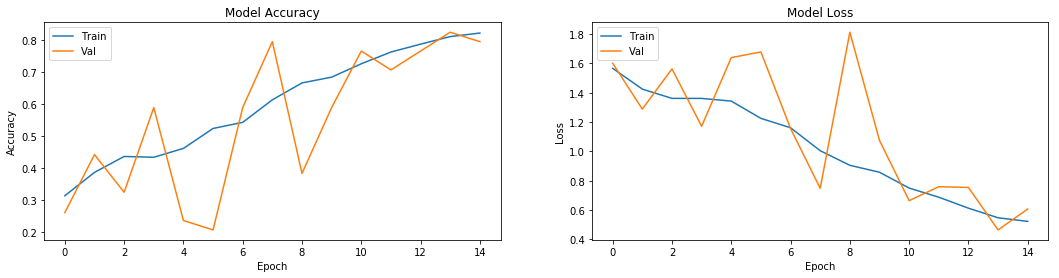

In [16]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = cnn_rnn_lstm(input_shape, num_classes)

# Batch size
batch_size = 3

# Number of Epochs
num_epochs = 15

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)


<h3><u>Experimentation with 5th Model starts from here </u><h3> 
<h5>Having achieved the best accuracy with the small batch size. For experimentation with next 2 CNN+RNN architectures, we will keep the batch size as 3 </h5>

#### Train the CCN + RNN(GRU) Model

<h3> Experiment - 19</h3>
This is the 5th Model. <br>
without any Dropouts after the Convolution layers but Droput in Fully Connected layer and Batch normalization in the FC layer. <br>
This trining is done on the input image with: <br>
1. The data is doubled using the Augumentation Technique of Affine Transformation. <br>
2. The images are flipped to add more generalization to the data set.

# training sequences = 663
# validation sequences = 100
# batch size = 3
# Numbe of epochs = 13
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 29, 29, 64)    36928     
______________________________________________

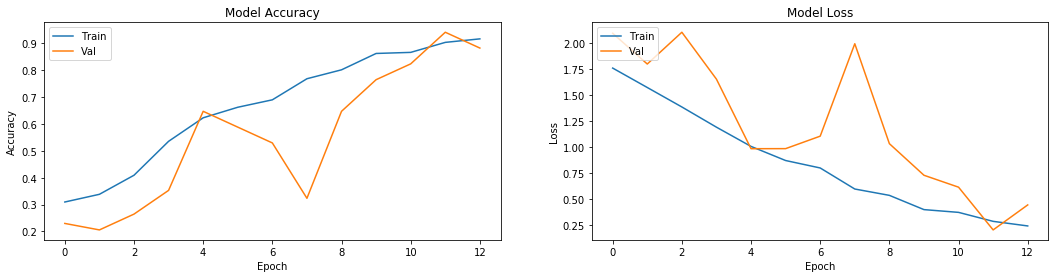

In [17]:
# Instantiate the data_generator class
train_gen = data_generator(affine=True, flip=True)
val_gen = data_generator()


# Input shape:
# Number of Frames = 30
# Number of rows (X dimension of the image) = 120
# Number of columns (Y dimension of the image) = 120
# Number of Channels = 3
input_shape = (30,120,120, 3)

# Number of output classes
num_classes = 5

# Generate the Model
model = cnn_rnn_gru(input_shape, num_classes)

# Batch size
batch_size = 3

# Number of Epochs
num_epochs = 13

# Preprocess the training images and generate the training data
train_generator = train_gen.generator(train_path, train_doc, batch_size)
# Preprocess the validation images and generate the validation data
val_generator = val_gen.generator(val_path, val_doc, batch_size)
# Train the Model
train_model(batch_size, num_epochs, model, train_generator, val_generator)
